In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant

In [2]:
# Daily 손익으로 변환해준다
def change_weekly_to_daily(weekly_price_df, weekly_rtn_df, weekly_weight_df, daily_price, freq):
    '''모든 데이터는 Weekly로 줘야함
       daily_df에 아무런 데일리 데이터를 주면 됨(빈 데이터프레임 형성시에 필요함)'''
    pf_weekly_value = ((weekly_rtn_df * weekly_weight_df.shift(1)).sum(1) + 1).cumprod()
    each_input_money = (weekly_weight_df.T * pf_weekly_value).T # toy df,s 실험으로 찾음
    how_many_coin = each_input_money / weekly_price_df 
    daily_coin_converted = pd.DataFrame(index=daily_price.loc[freq:].index,  # 여기서 weight말고 코인 개수를 ffill 해야함
                                        columns=daily_price.loc[freq:].columns) \
                                    .fillna(how_many_coin) \
                                    .ffill(limit=6) 
                                    
    pf_value = ((daily_price * daily_coin_converted).loc[freq:].sum(1) \
                                                  .pct_change(fill_method=None)) \
                                                  .fillna(0)
    return pf_value

def calculate_cagr(return_df):
    '''rtn을 받았을 때, CAGR을 계산합니다'''
    holding_year = (len(return_df) / 365)
    cum = (return_df+1).cumprod()
    cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
    return cagr

def run_alpha_regression(return_dict:dict, 
                         mkt_rtn:pd.DataFrame,
                         constant=True):
    
    '''return_dict : 포트폴리오 리턴(dict)
       mkt_rtn : 마켓 인덱스의 리턴이 들어감
       constant : True(Default)/ False
       '''
    
    for key, strategy_df in return_dict.items():  
        if str(key) =="count":
            continue
        
        if constant:
            model = OLS(strategy_df, add_constant(mkt_rtn))
        else:
            model = OLS(strategy_df, mkt_rtn)
        result = model.fit()
        
        print(f"{key} Regression Result")
        print(result.summary2())
        
def print_statistics(return_dict:dict,
                     mkt_rtn:pd.DataFrame):
        
    mean = [df.mean().round(6) for key, df in return_dict.items()]          
    std = [df.std() for key, df in return_dict.items()]
    cagr =[calculate_cagr(df) * 100 for key, df in return_dict.items()]          
    return_df = pd.DataFrame([cagr,mean,std], 
                             index=["CAGR", "Mean","STD"])
    
    
    mkt = pd.DataFrame([calculate_cagr(mkt_rtn) * 100, mkt_rtn.mean(), mkt_rtn.std()],
                           index=["CAGR", "Mean","STD"], 
                           columns=["MKT"])
    
    return_df = pd.concat([return_df, mkt], axis=1)
    return_df.loc["Shape",:] = (return_df.loc["Mean",:]*365)/ (return_df.loc["STD",:]*np.sqrt(365))
    return return_df
        
def draw_return_result(return_dict:dict, 
                       with_mkt=False,
                       mkt_rtn=None):
    
    '''rtn_result : dict(리턴이 담긴 딕셔러니)
       with_mkt   : bool -> 마켓인덱스를 함께 그릴지 표시
       with_mkt가 True일 경우 mkt_rtn을 줘야한다'''
        
    for key, df in return_dict.items():
        fig, axes = plt.subplots(3,1, sharex=True, figsize=(24,24), 
                                 gridspec_kw={'height_ratios': [4, 1, 1]})
        cum_df = (df+1).cumprod()
        cum_df.plot(ax=axes[0])
            
        axes[0].set_title("Cross-Sectional Momentum Cummulative returns weighted by marketcap")
        axes[0].grid()
        axes[0].legend(["Startegy","MKT"])
        
        peak = cum_df.cummax()
        drawdown = (cum_df-peak)/peak
        drawdown.plot(ax=axes[1])
        axes[1].set_title("Draw Down")
        axes[1].grid()
        
        df.plot(ax=axes[2])
        axes[2].grid()
        
        if with_mkt:
            mktcum = (mkt_rtn+1).cumprod()
            mktcum.plot(ax=axes[0])
            axes[0].grid()
            axes[0].legend(["Startegy","MKT"])
            
            peak = mktcum.cummax()
            drawdown = (mktcum-peak) / peak
            drawdown.plot(ax=axes[1], alpha=0.3)
            axes[1].grid()
            
            mkt_rtn.plot(ax=axes[2], alpha=0.3)
            axes[2].grid();      

# 마켓인덱스

Vol 0으로 스크리닝한 Return 계산

In [3]:
mktcap = pd.read_pickle("ryu_new_mktcap9.pickle")
price = pd.read_pickle("ryu_new_price9.pickle")
vol = pd.read_pickle("ryu_new_volume9.pickle")

rtn = price.pct_change(fill_method=None) * np.sign(price)
#weight = mktcap.apply(lambda x: x/ np.nansum(x), axis=1)

vol_mask = (vol > 0).replace(False, np.nan)
vol_mask = (vol.rolling(window=20, min_periods=5).mean() > 1_000_000)\
               .replace({False: np.nan, True: 1})
               
new_mktcap = (vol_mask * mktcap)

In [4]:
# new_mktcap이 0보다 큰 날을 찾아보자
sum_num = (~new_mktcap.isna()).sum(1)
sum_num.loc[sum_num>0]

2013-12-27      1
2013-12-28      2
2013-12-29      2
2013-12-30      2
2013-12-31      2
             ... 
2023-03-06    464
2023-03-07    463
2023-03-08    456
2023-03-09    454
2023-03-10    453
Length: 3361, dtype: int64

In [5]:
new_weight = new_mktcap.loc["2013-12-27":].apply(lambda x:x/np.nansum(x), axis=1)

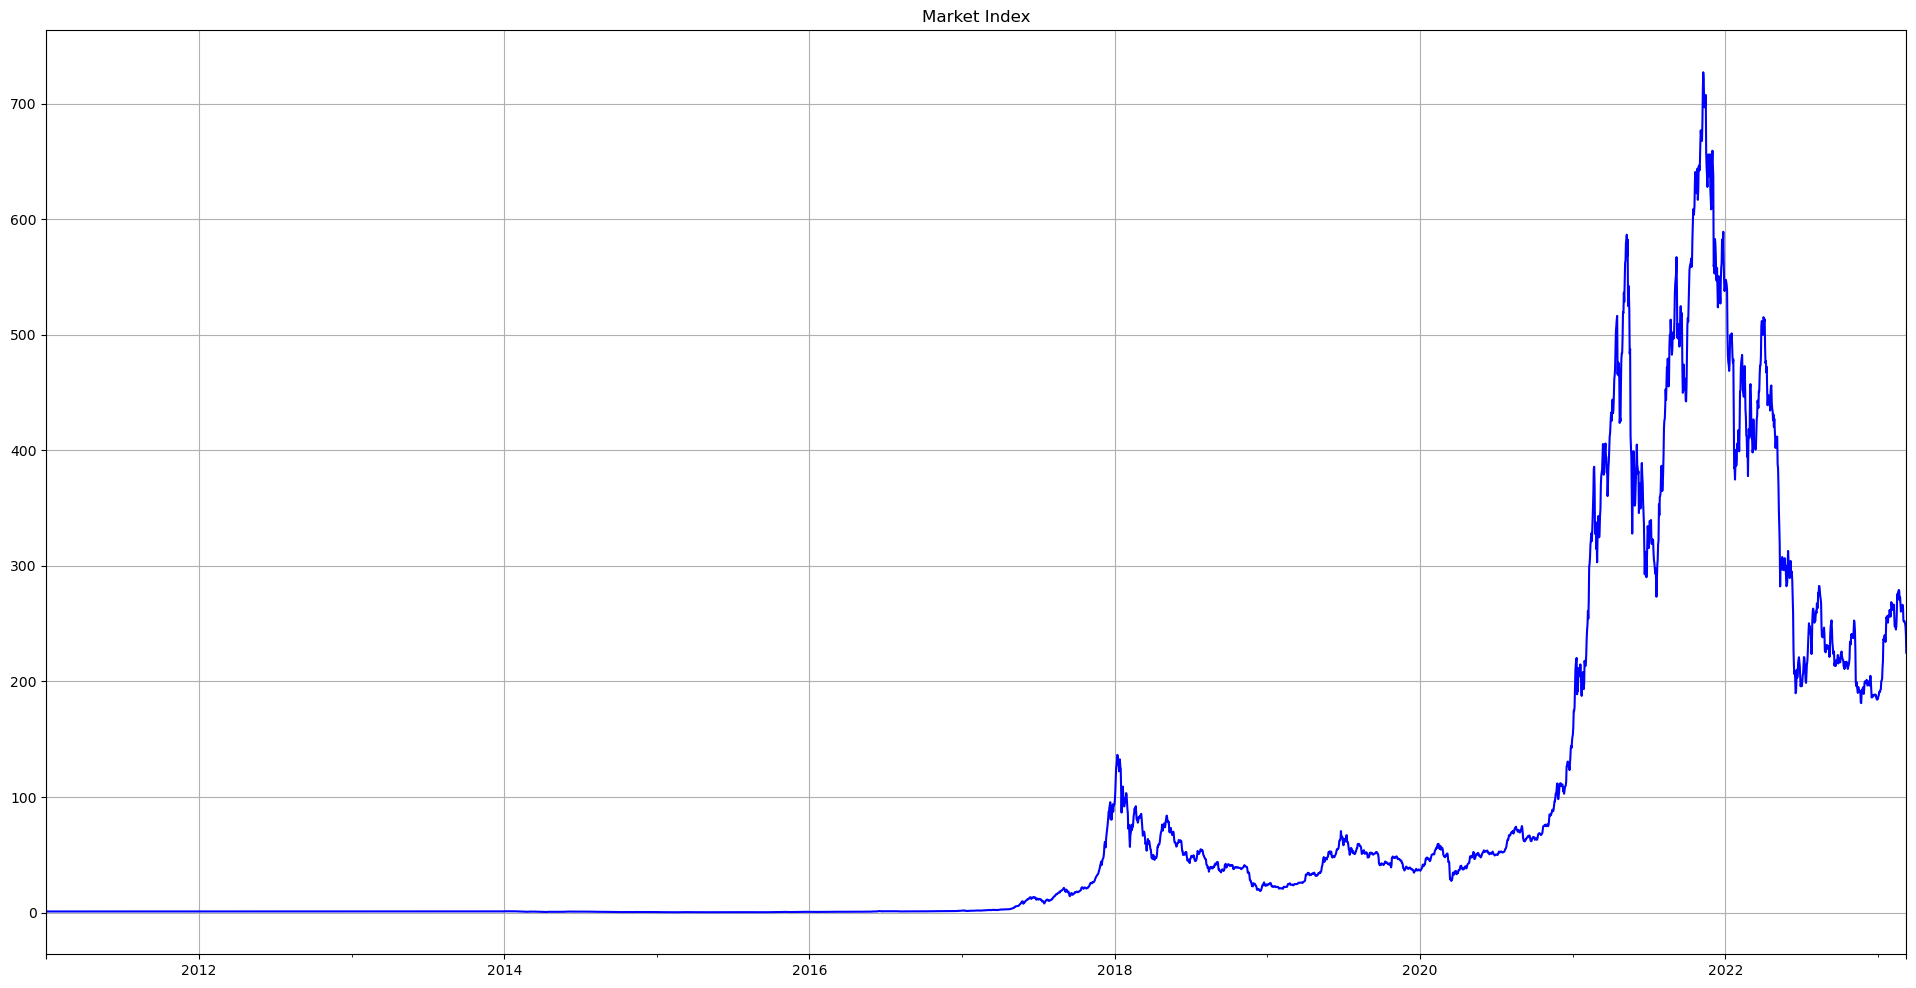

In [6]:
fig, axes = plt.subplots(1,1)

# 마켓 리턴      "2013-12-27"
mkt_rtn = ((rtn.loc[:] * new_weight).sum(1))
(mkt_rtn+1).cumprod().plot(figsize=(24,12), ax=axes, c="b")

# btc 리턴     "2013-04-29":"2018"
#btc = price.loc[:][["BTC"]]
#(btc / btc.iloc[0]) \
#.plot(figsize=(24,12), ax=axes, c="r");

plt.grid()
plt.title("Market Index");

Cross-Sectional : Weekly Rebalancing

In [7]:
mktcap = pd.read_pickle("ryu_new_mktcap9.pickle")
price  = pd.read_pickle("ryu_new_price9.pickle")
vol = pd.read_pickle("ryu_new_volume9.pickle")

daily_rtn = price.pct_change(fill_method=None) * np.sign(price)
#vol_screener = (vol > 0).replace({True:1, 
#                                  False:np.nan})
vol_screener = (vol.rolling(window=20, min_periods=5).mean() > 1_000_000)\
                   .replace({False: np.nan, True: 1})


# vol>0 은 너무 당연한거라 변수명을 그냥 daily, weekly로만 해주겠음
daily_mktcap=  vol_screener * mktcap
weekly_mktcap = daily_mktcap.resample("W").last()

weekly_rtn = (price * vol_screener).pct_change(7, fill_method=None) \
                                        .resample("W").last() \
                         * np.sign(price.resample("W").last())

In [8]:
weekly_price = price.resample("W").last()

In [9]:
# 언제부터 시작하는 지 찾자 (최소 100개의 코인이 필요)
cnt = daily_mktcap.count(1)
cnt.loc[cnt > 99]

2017-12-12    100
2017-12-13    103
2017-12-14    104
2017-12-15    108
2017-12-16    113
             ... 
2023-03-06    464
2023-03-07    463
2023-03-08    456
2023-03-09    454
2023-03-10    453
Length: 1912, dtype: int64

In [10]:
# return도 같은 기간으로 잘라야함
start_date = "2017-12-12"
weekly_rtn_sample = weekly_rtn.loc[start_date:]
weekly_mktcap_sample = weekly_mktcap.loc[start_date:]

# 나중에 plot할때도 필요해서 market rtn도 구해둬야한다
mktrtn_sample = mkt_rtn.loc["2017-12-17":]

In [11]:
# 각 그룹의 filter를 구하고, 그것을 mkt와 곱한이후, 각 그룹의 weight를 구해야하는데, mktcap과 곱하는 과정에서 없어지는 코인이 너무 많은것
## 해결 -> mktcap으로 마스킹

## 우선 mktcap에 음수값이 있는 지 확인
print((weekly_mktcap_sample <= 0).sum().sum())

weekly_rtn_sample_pp = weekly_rtn_sample * np.sign(weekly_mktcap_sample)

0


In [12]:
# rank를 계산해줍니다
rank = weekly_rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//5)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])
t4 = rank_thresh.apply(lambda x: x[4])

rank_thresh

2017-12-17        [0, 19, 38, 57, 76, 95]
2017-12-24            [0, 23, 46, 69, 92]
2017-12-31      [0, 28, 56, 84, 112, 140]
2018-01-07      [0, 31, 62, 93, 124, 155]
2018-01-14     [0, 35, 70, 105, 140, 175]
                         ...             
2023-02-12    [0, 89, 178, 267, 356, 445]
2023-02-19    [0, 93, 186, 279, 372, 465]
2023-02-26         [0, 94, 188, 282, 376]
2023-03-05    [0, 93, 186, 279, 372, 465]
2023-03-12         [0, 92, 184, 276, 368]
Freq: W-SUN, Length: 274, dtype: object

In [13]:
g1_mask = rank.apply(lambda x: x <= t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 < x)&(x <= t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 < x)&(x <= t3), axis=0) \
              .replace({True:1, False:np.nan})
g4_mask = rank.apply(lambda x: (t3 < x)&(x <= t4), axis=0) \
              .replace({True:1, False:np.nan})
g5_mask = rank.apply(lambda x: x > t4, axis=0) \
              .replace({True:1, False:np.nan})           

In [14]:
# 각 그룹별 weight를 생성
weight_g1 = (g1_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g5 = (g5_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

In [15]:
# 그룹별 코인 개수 출력 
concat = pd.concat([weight_g1.count(1), weight_g2.count(1),
                    weight_g3.count(1), weight_g4.count(1),
                    weight_g5.count(1)], axis=1)#.plot();

coin = pd.concat([concat, concat.sum(1)], axis=1)
coin.columns = [0,1,2,3,4,"Sum"]

coin

,0,1,2,3,4,Sum
2017-12-17,19,19,19,19,20,96
2017-12-24,23,23,23,23,23,115
2017-12-31,28,28,28,28,30,142
2018-01-07,31,31,31,31,34,158
2018-01-14,35,35,35,35,37,177
...,...,...,...,...,...,...
2023-02-12,89,89,89,89,92,448
2023-02-19,93,93,93,93,97,469
2023-02-26,94,94,94,94,94,470
2023-03-05,93,93,93,93,97,469


<AxesSubplot:>

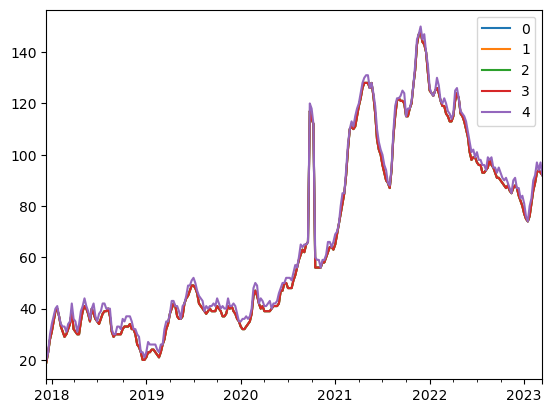

In [16]:
concat.plot()

In [17]:
# filter를 마켓켑과 리턴에 곱해줘서 각 그룹별 리턴 계산
rtn_g1 = (weekly_rtn_sample * weight_g1.shift(1)).sum(1)
rtn_g2 = (weekly_rtn_sample * weight_g2.shift(1)).sum(1)
rtn_g3 = (weekly_rtn_sample * weight_g3.shift(1)).sum(1)
rtn_g4 = (weekly_rtn_sample * weight_g4.shift(1)).sum(1)
rtn_g5 = (weekly_rtn_sample * weight_g5.shift(1)).sum(1)

In [18]:
start_date2 = "2017-12-17"

pf1 = change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g1, price, start_date2)
pf2 = change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g2, price, start_date2)
pf3 = change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g3, price, start_date2)
pf4 = change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g4, price, start_date2)
pf5 = change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g5, price, start_date2)

rtn_dict = {"Q1":pf1,
            "Q2":pf2,
            "Q3":pf3,
            "Q4":pf4,
            "Q5":pf5}

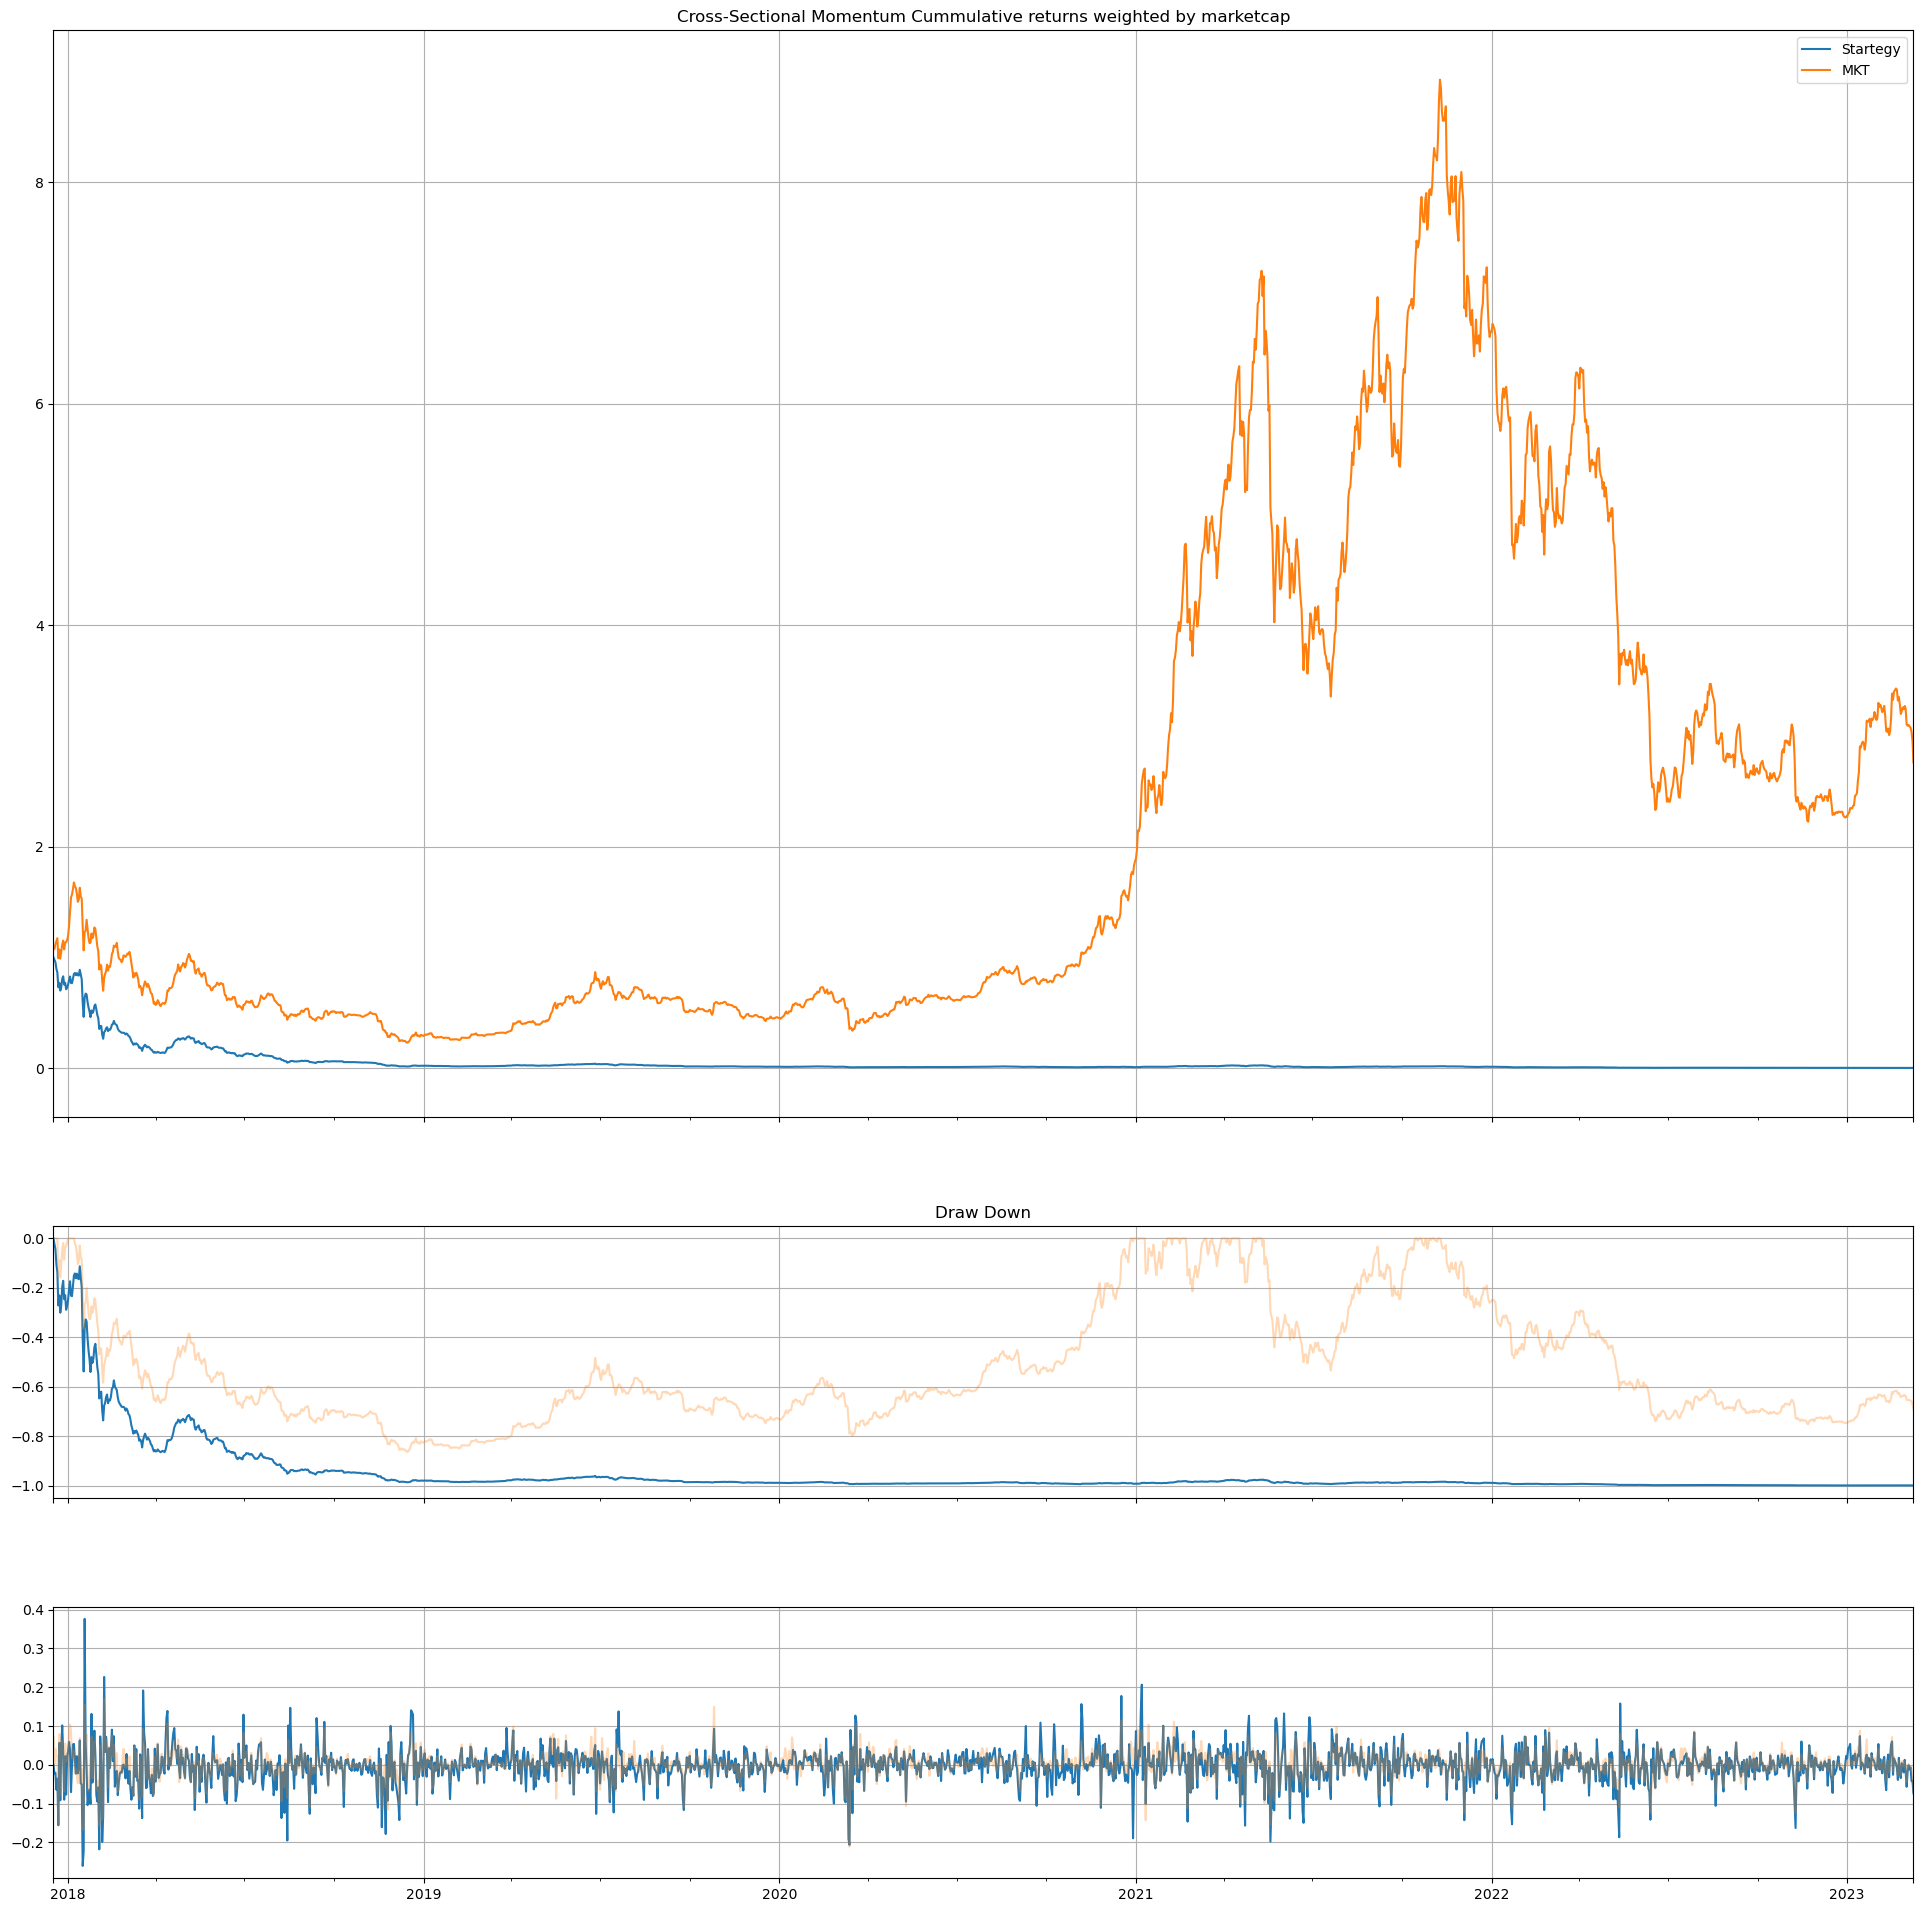

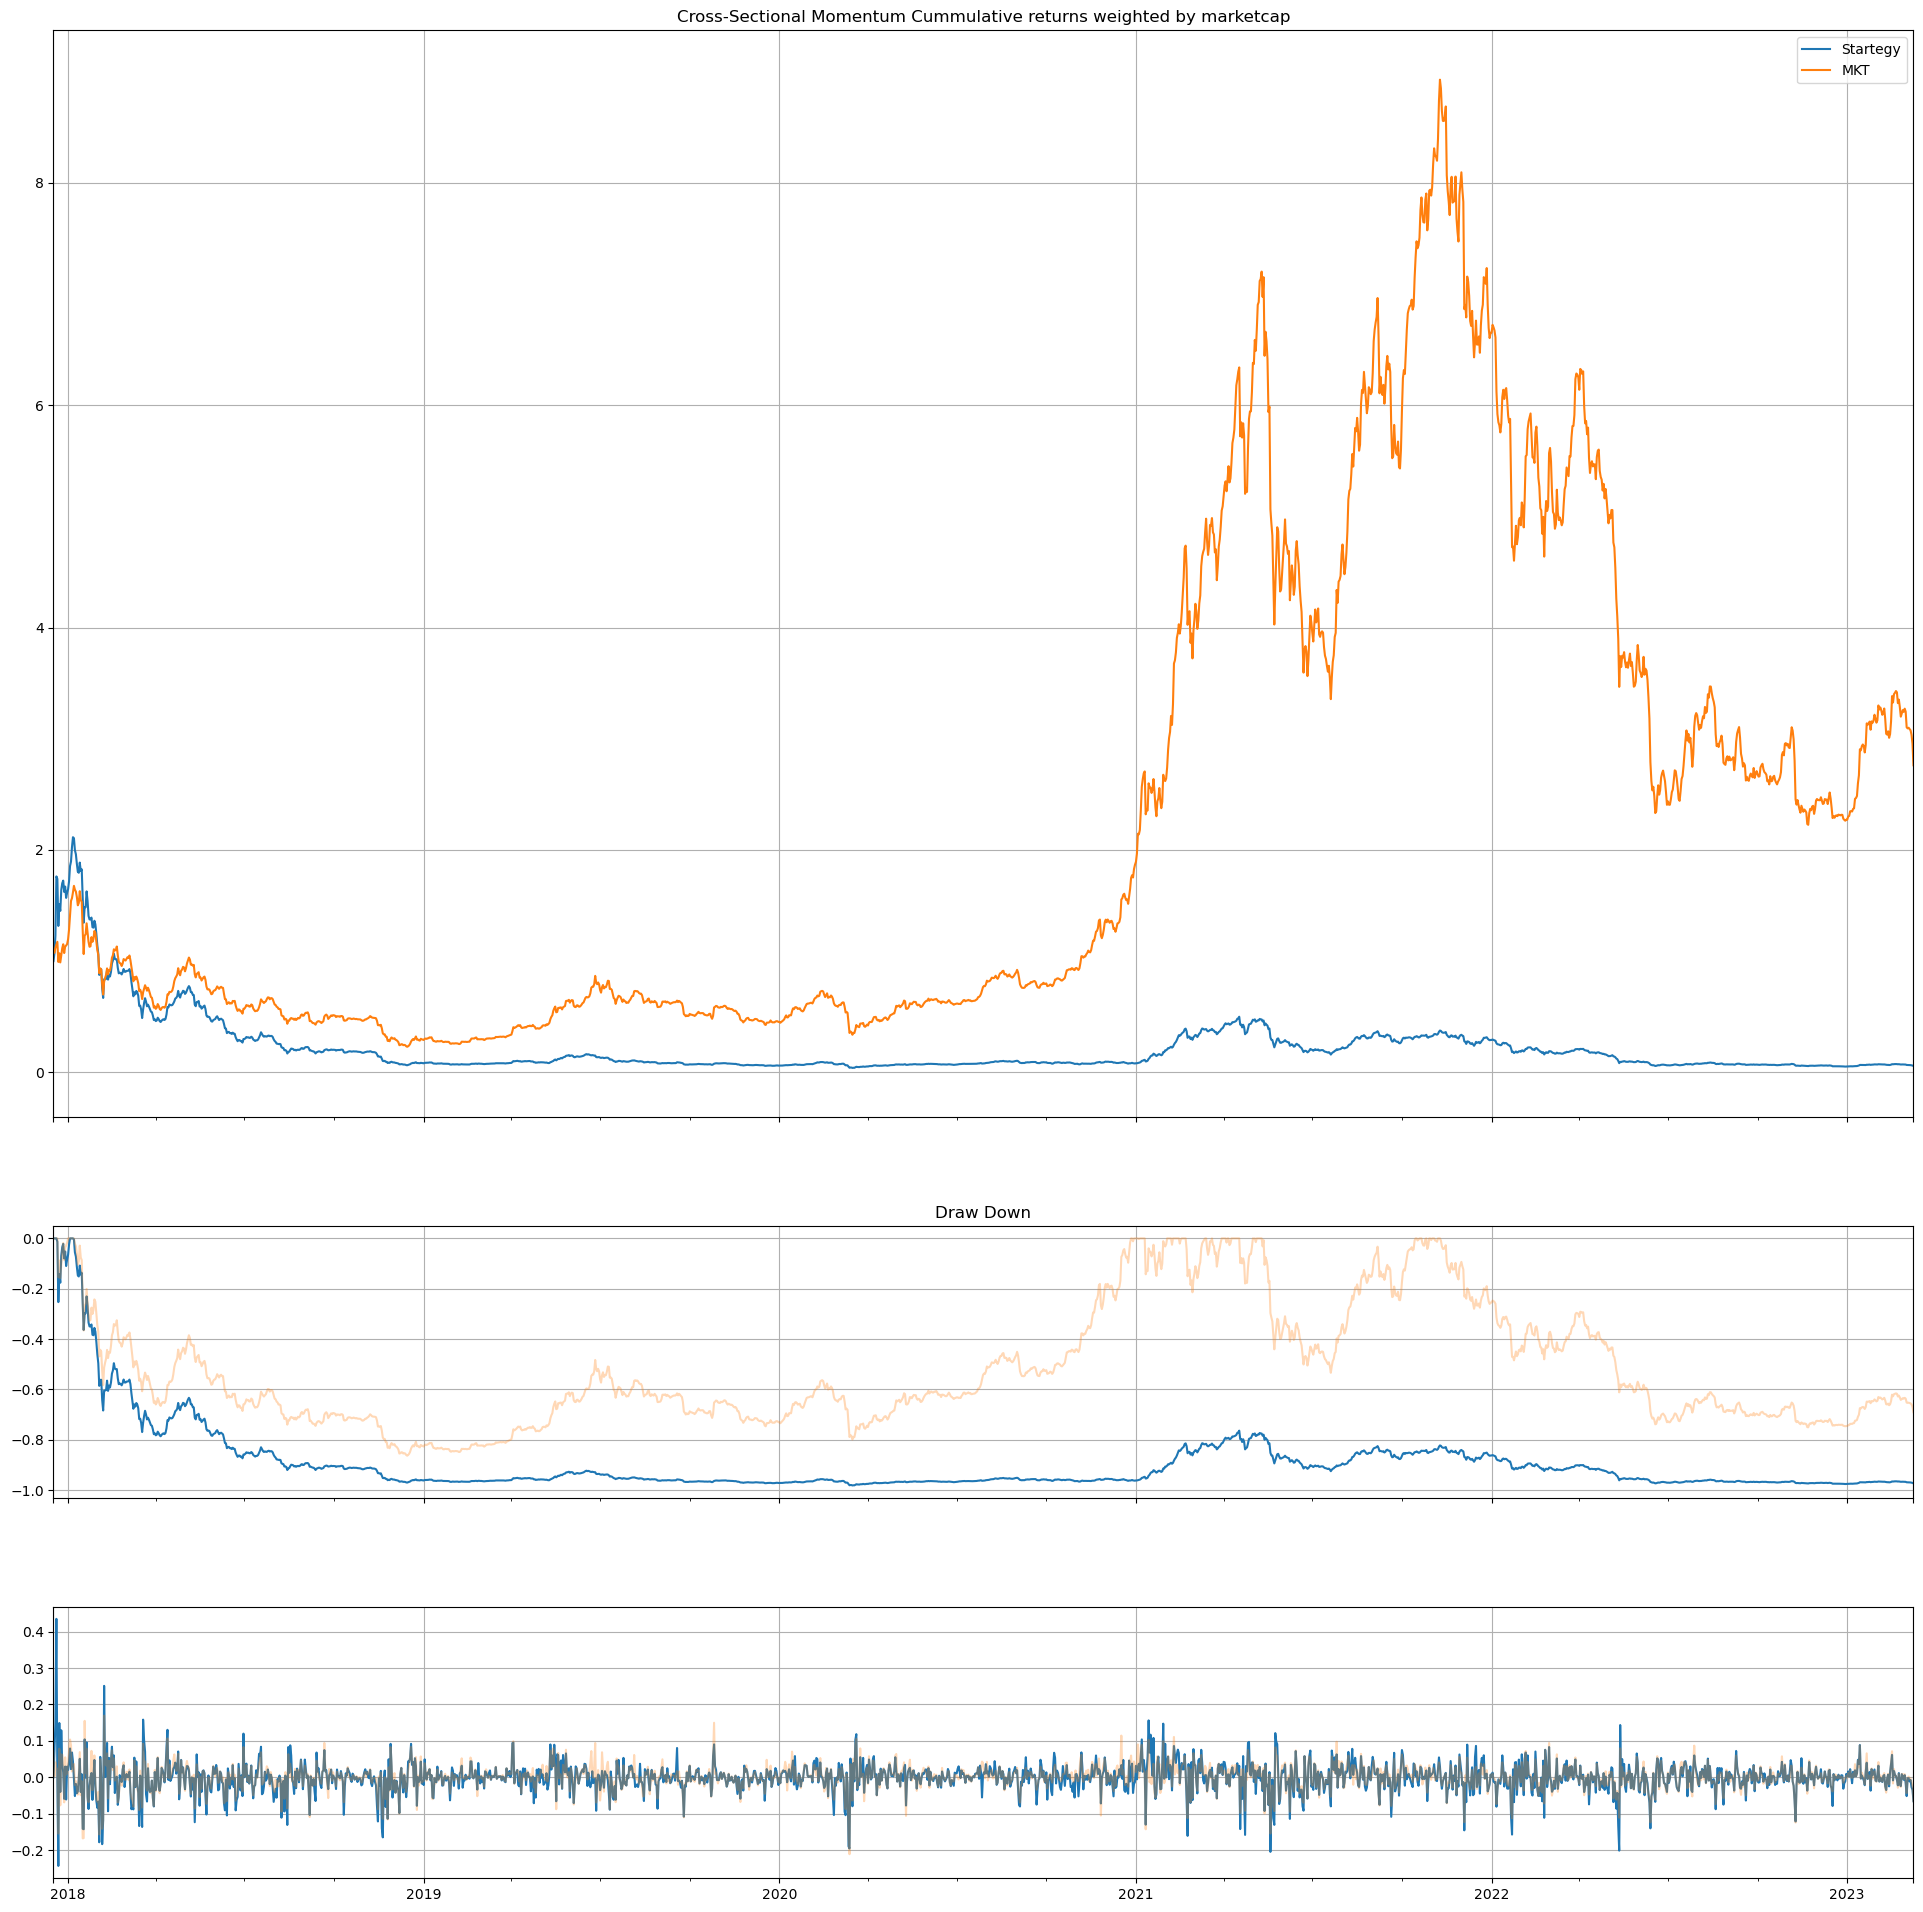

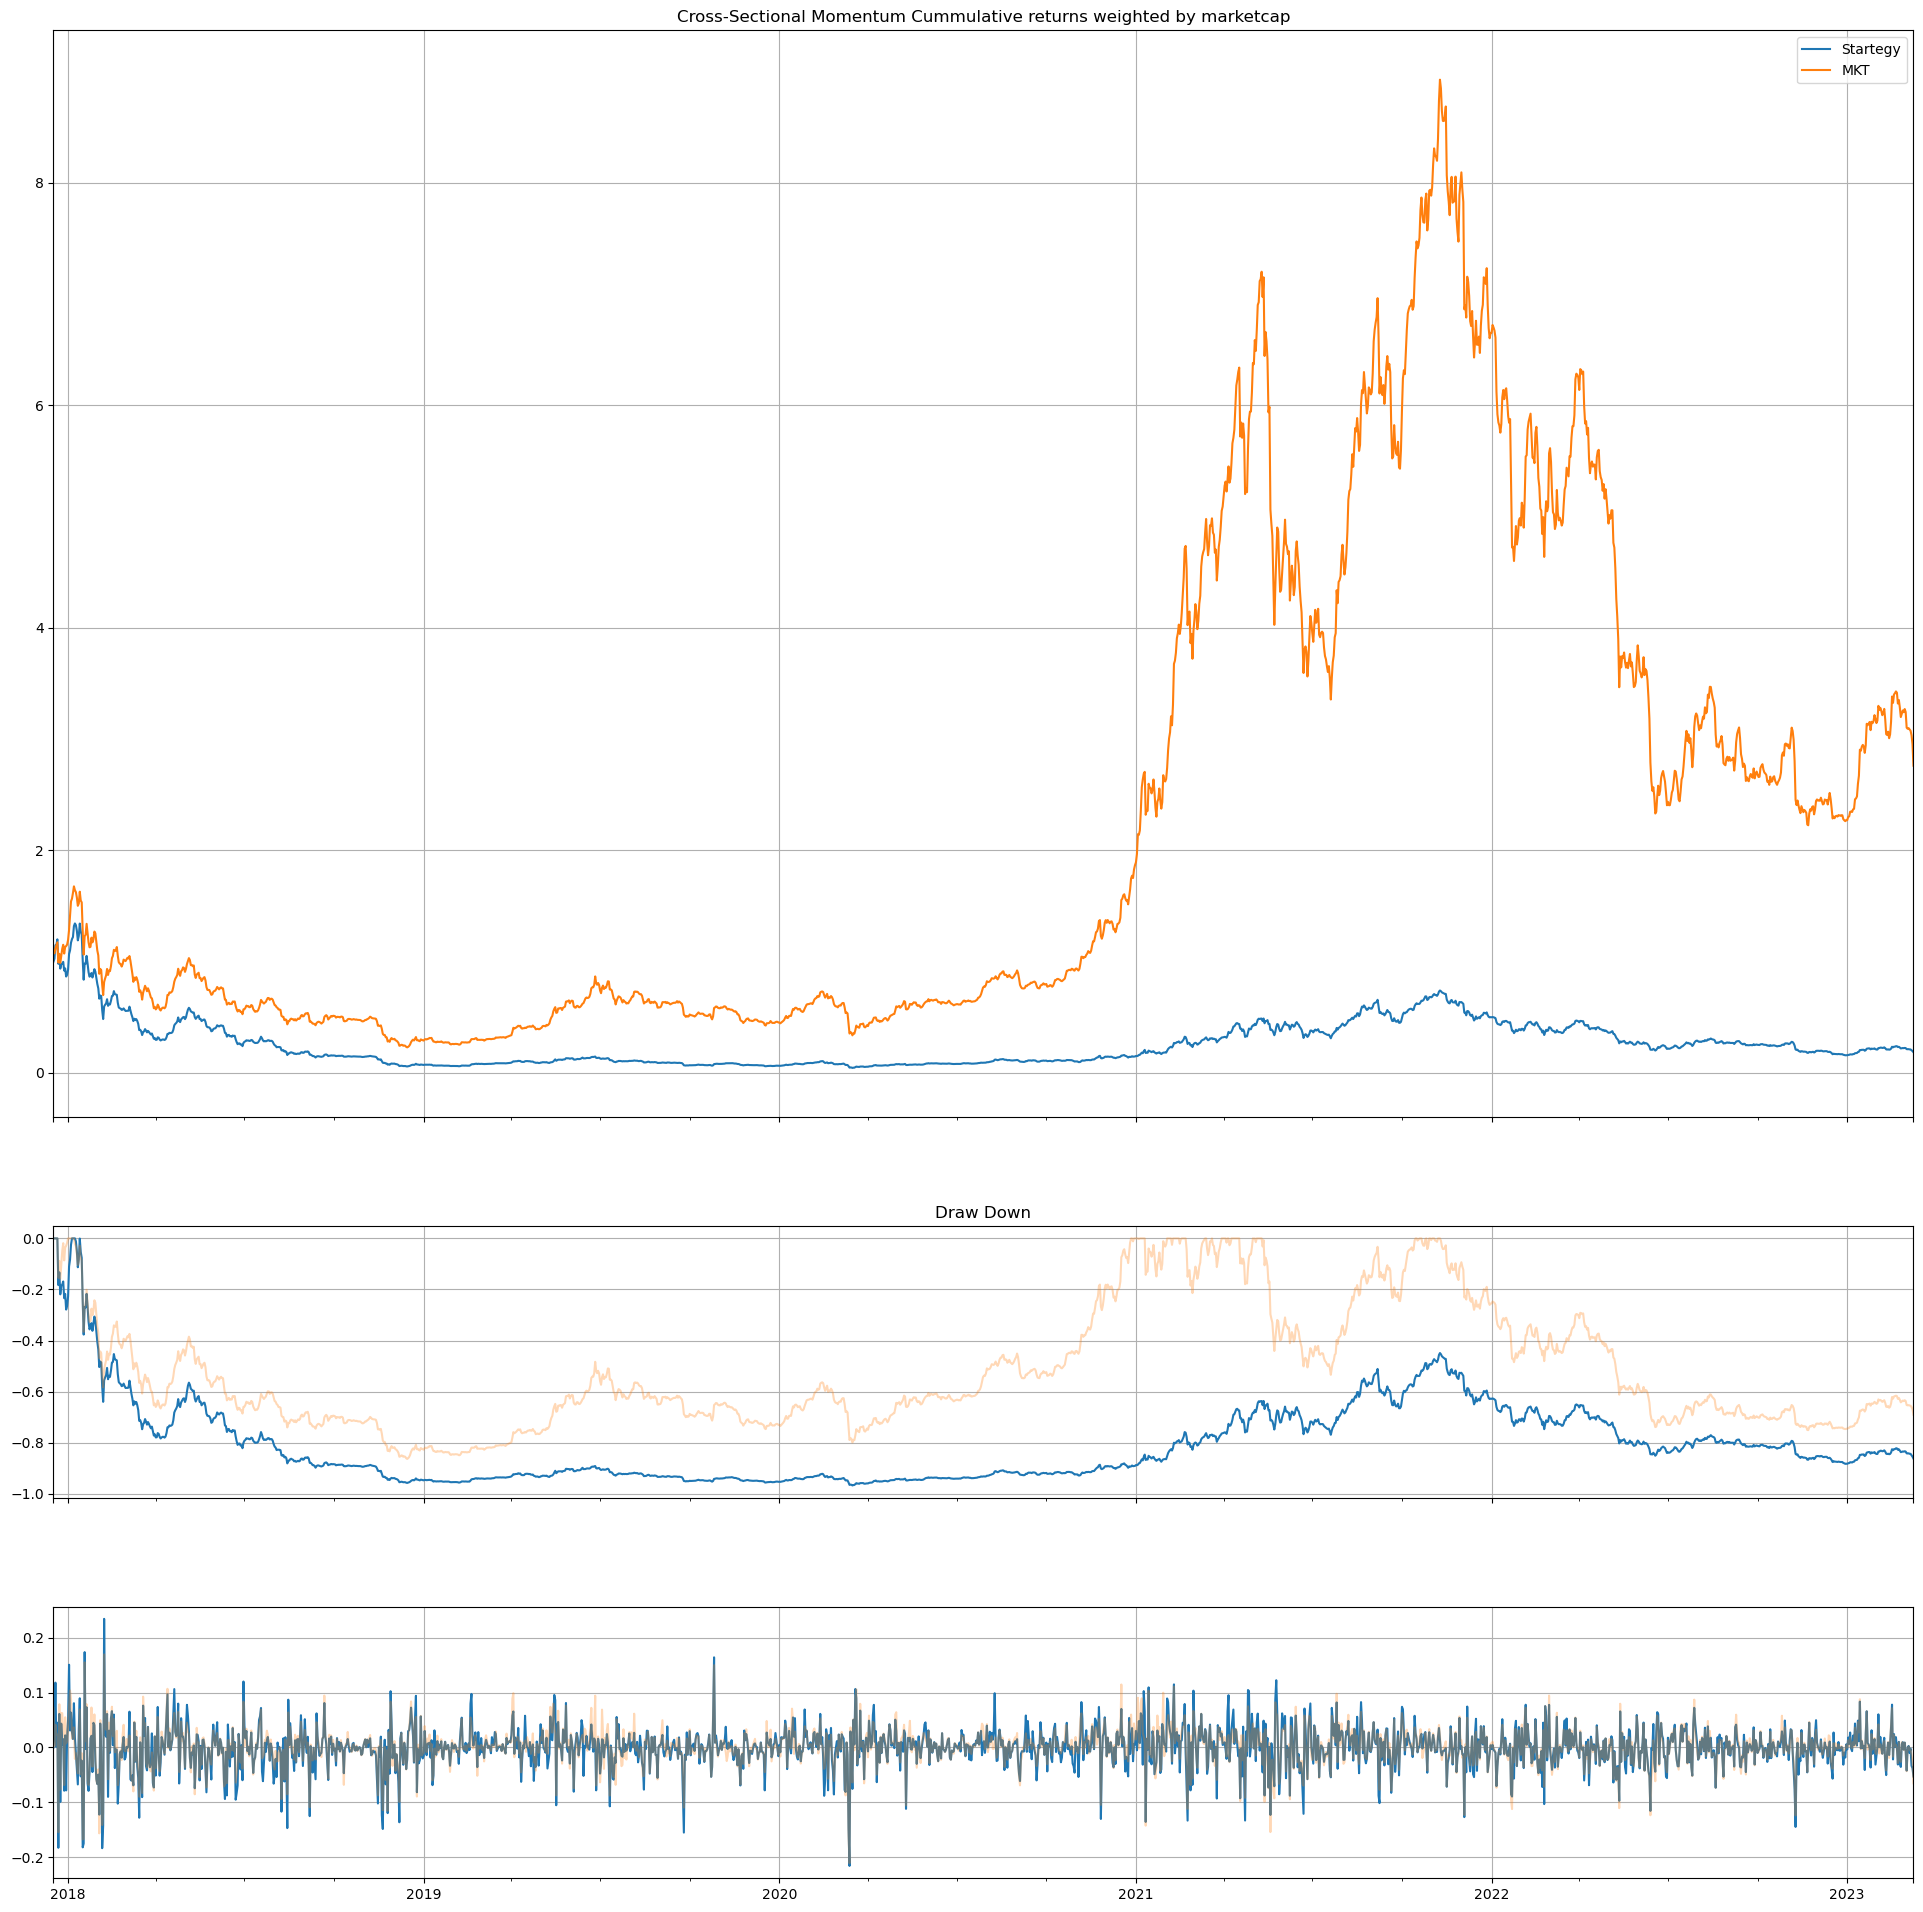

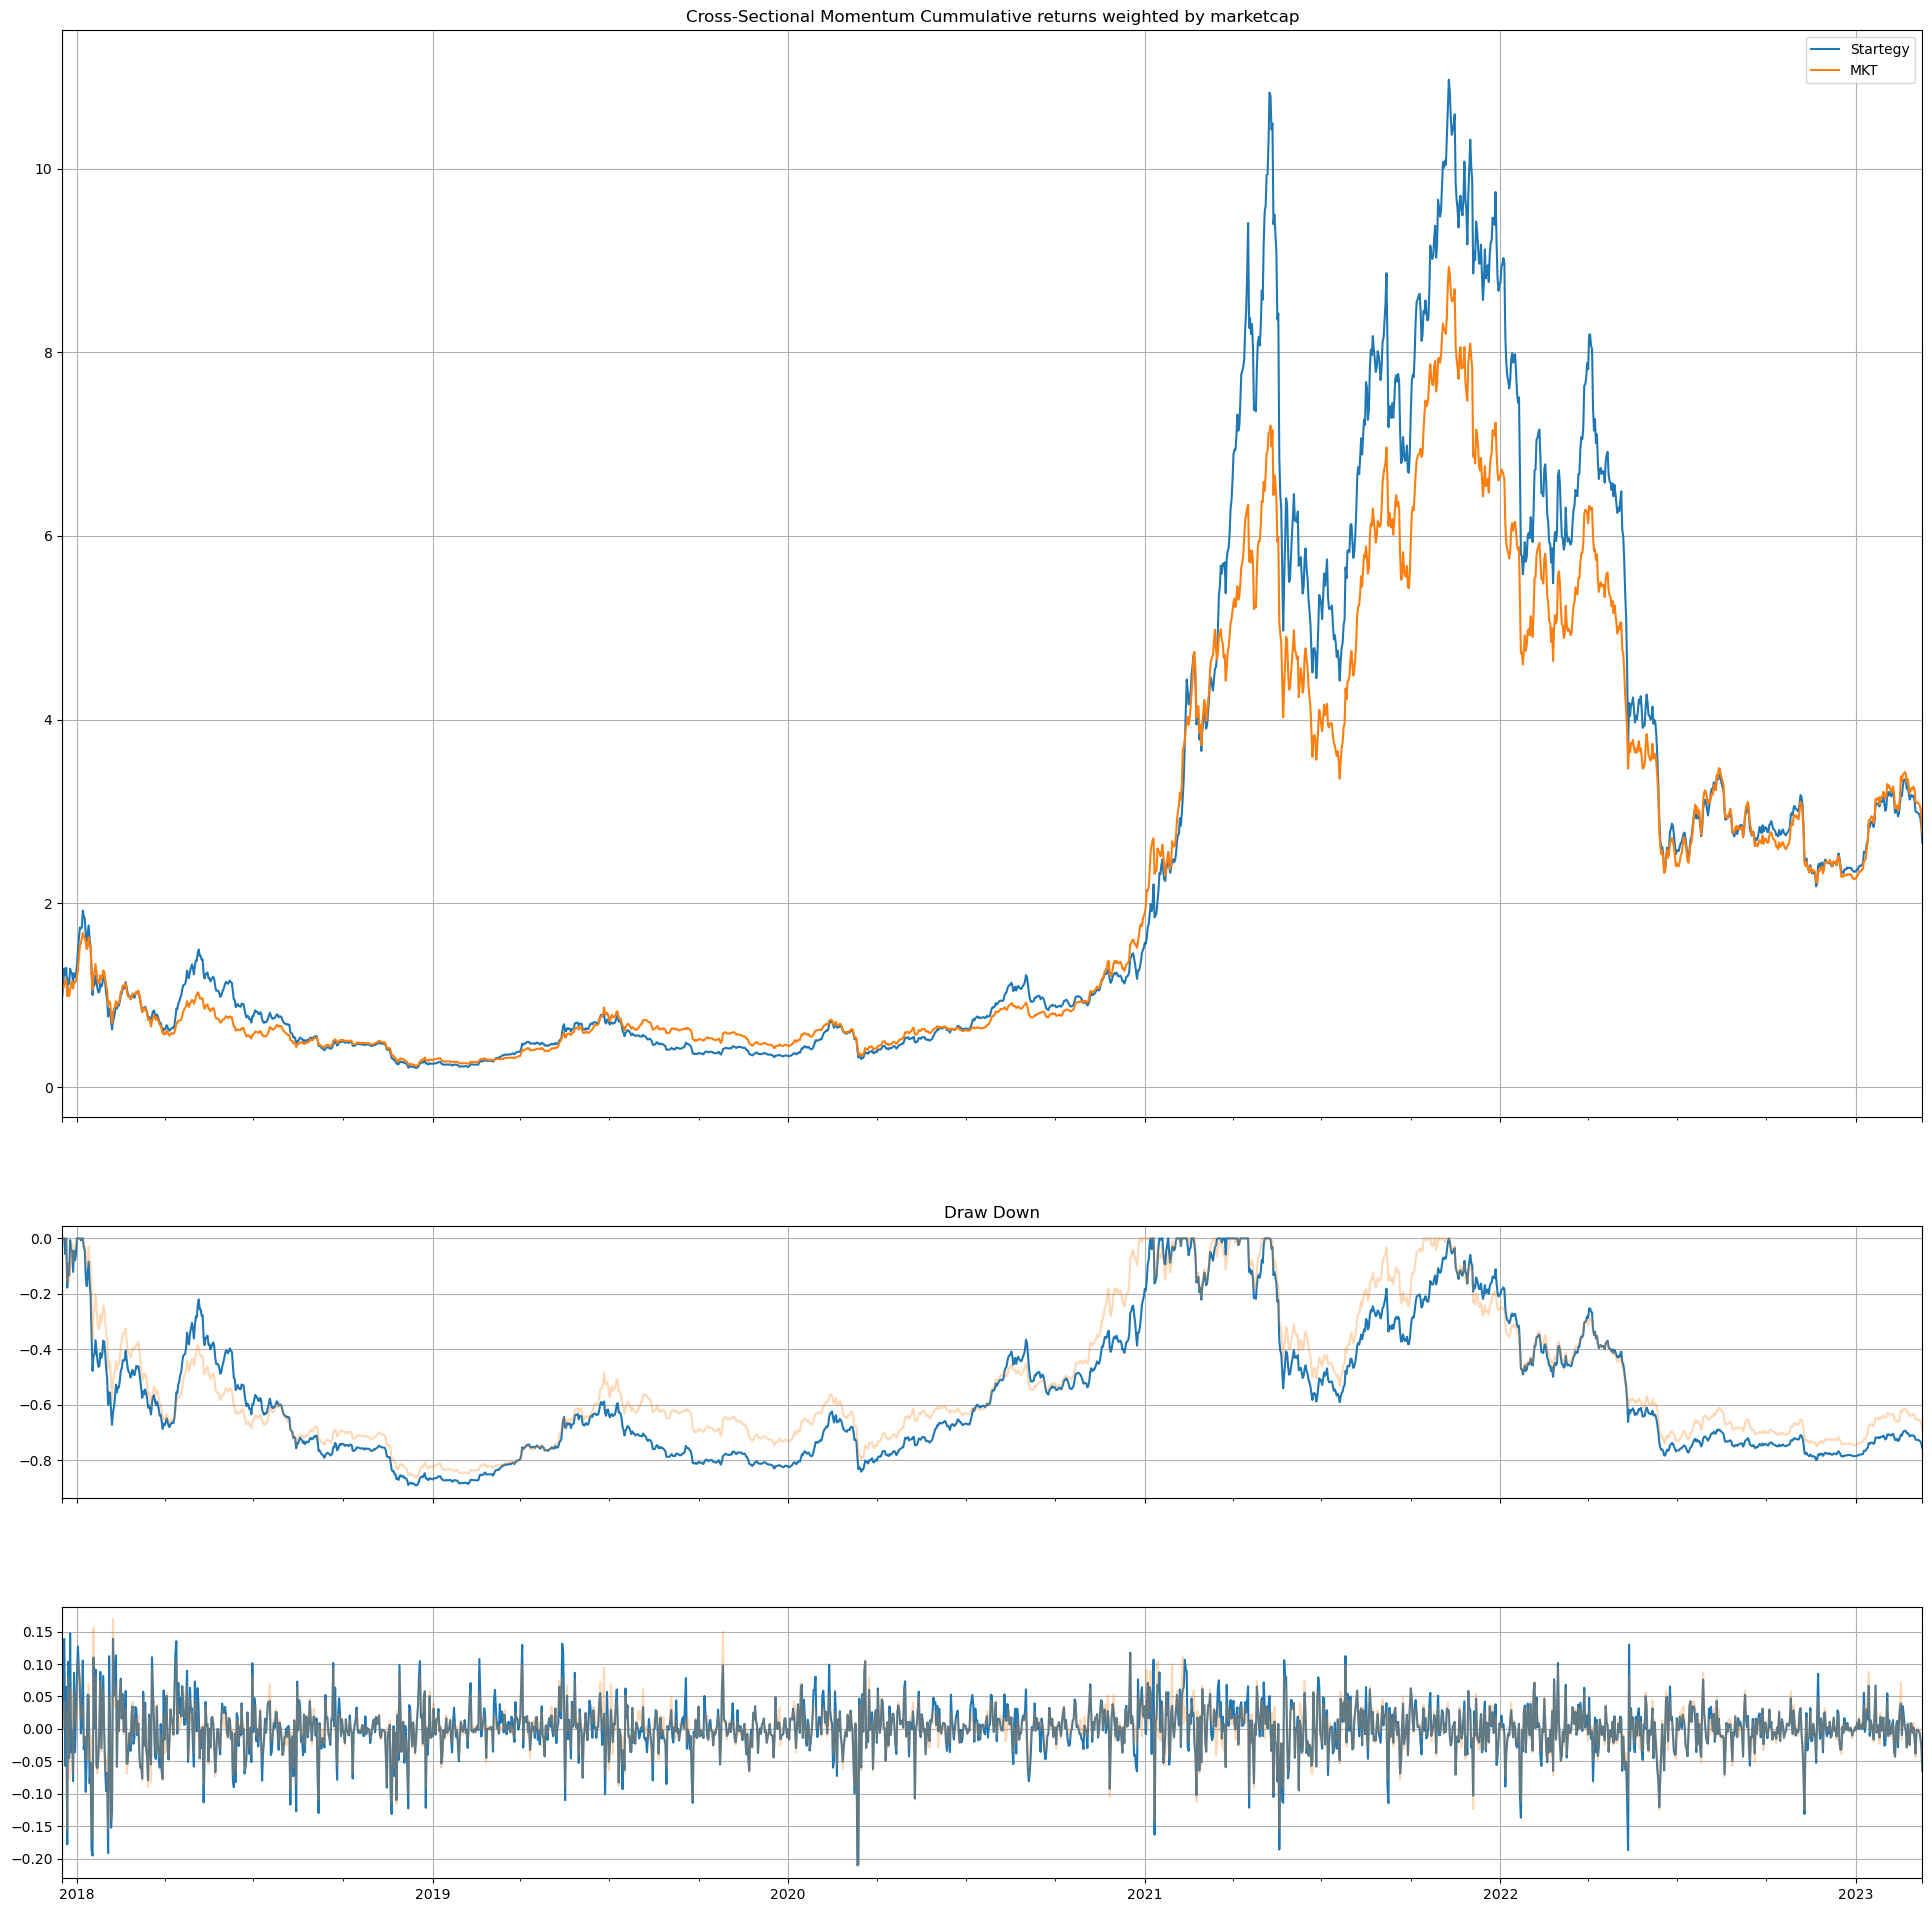

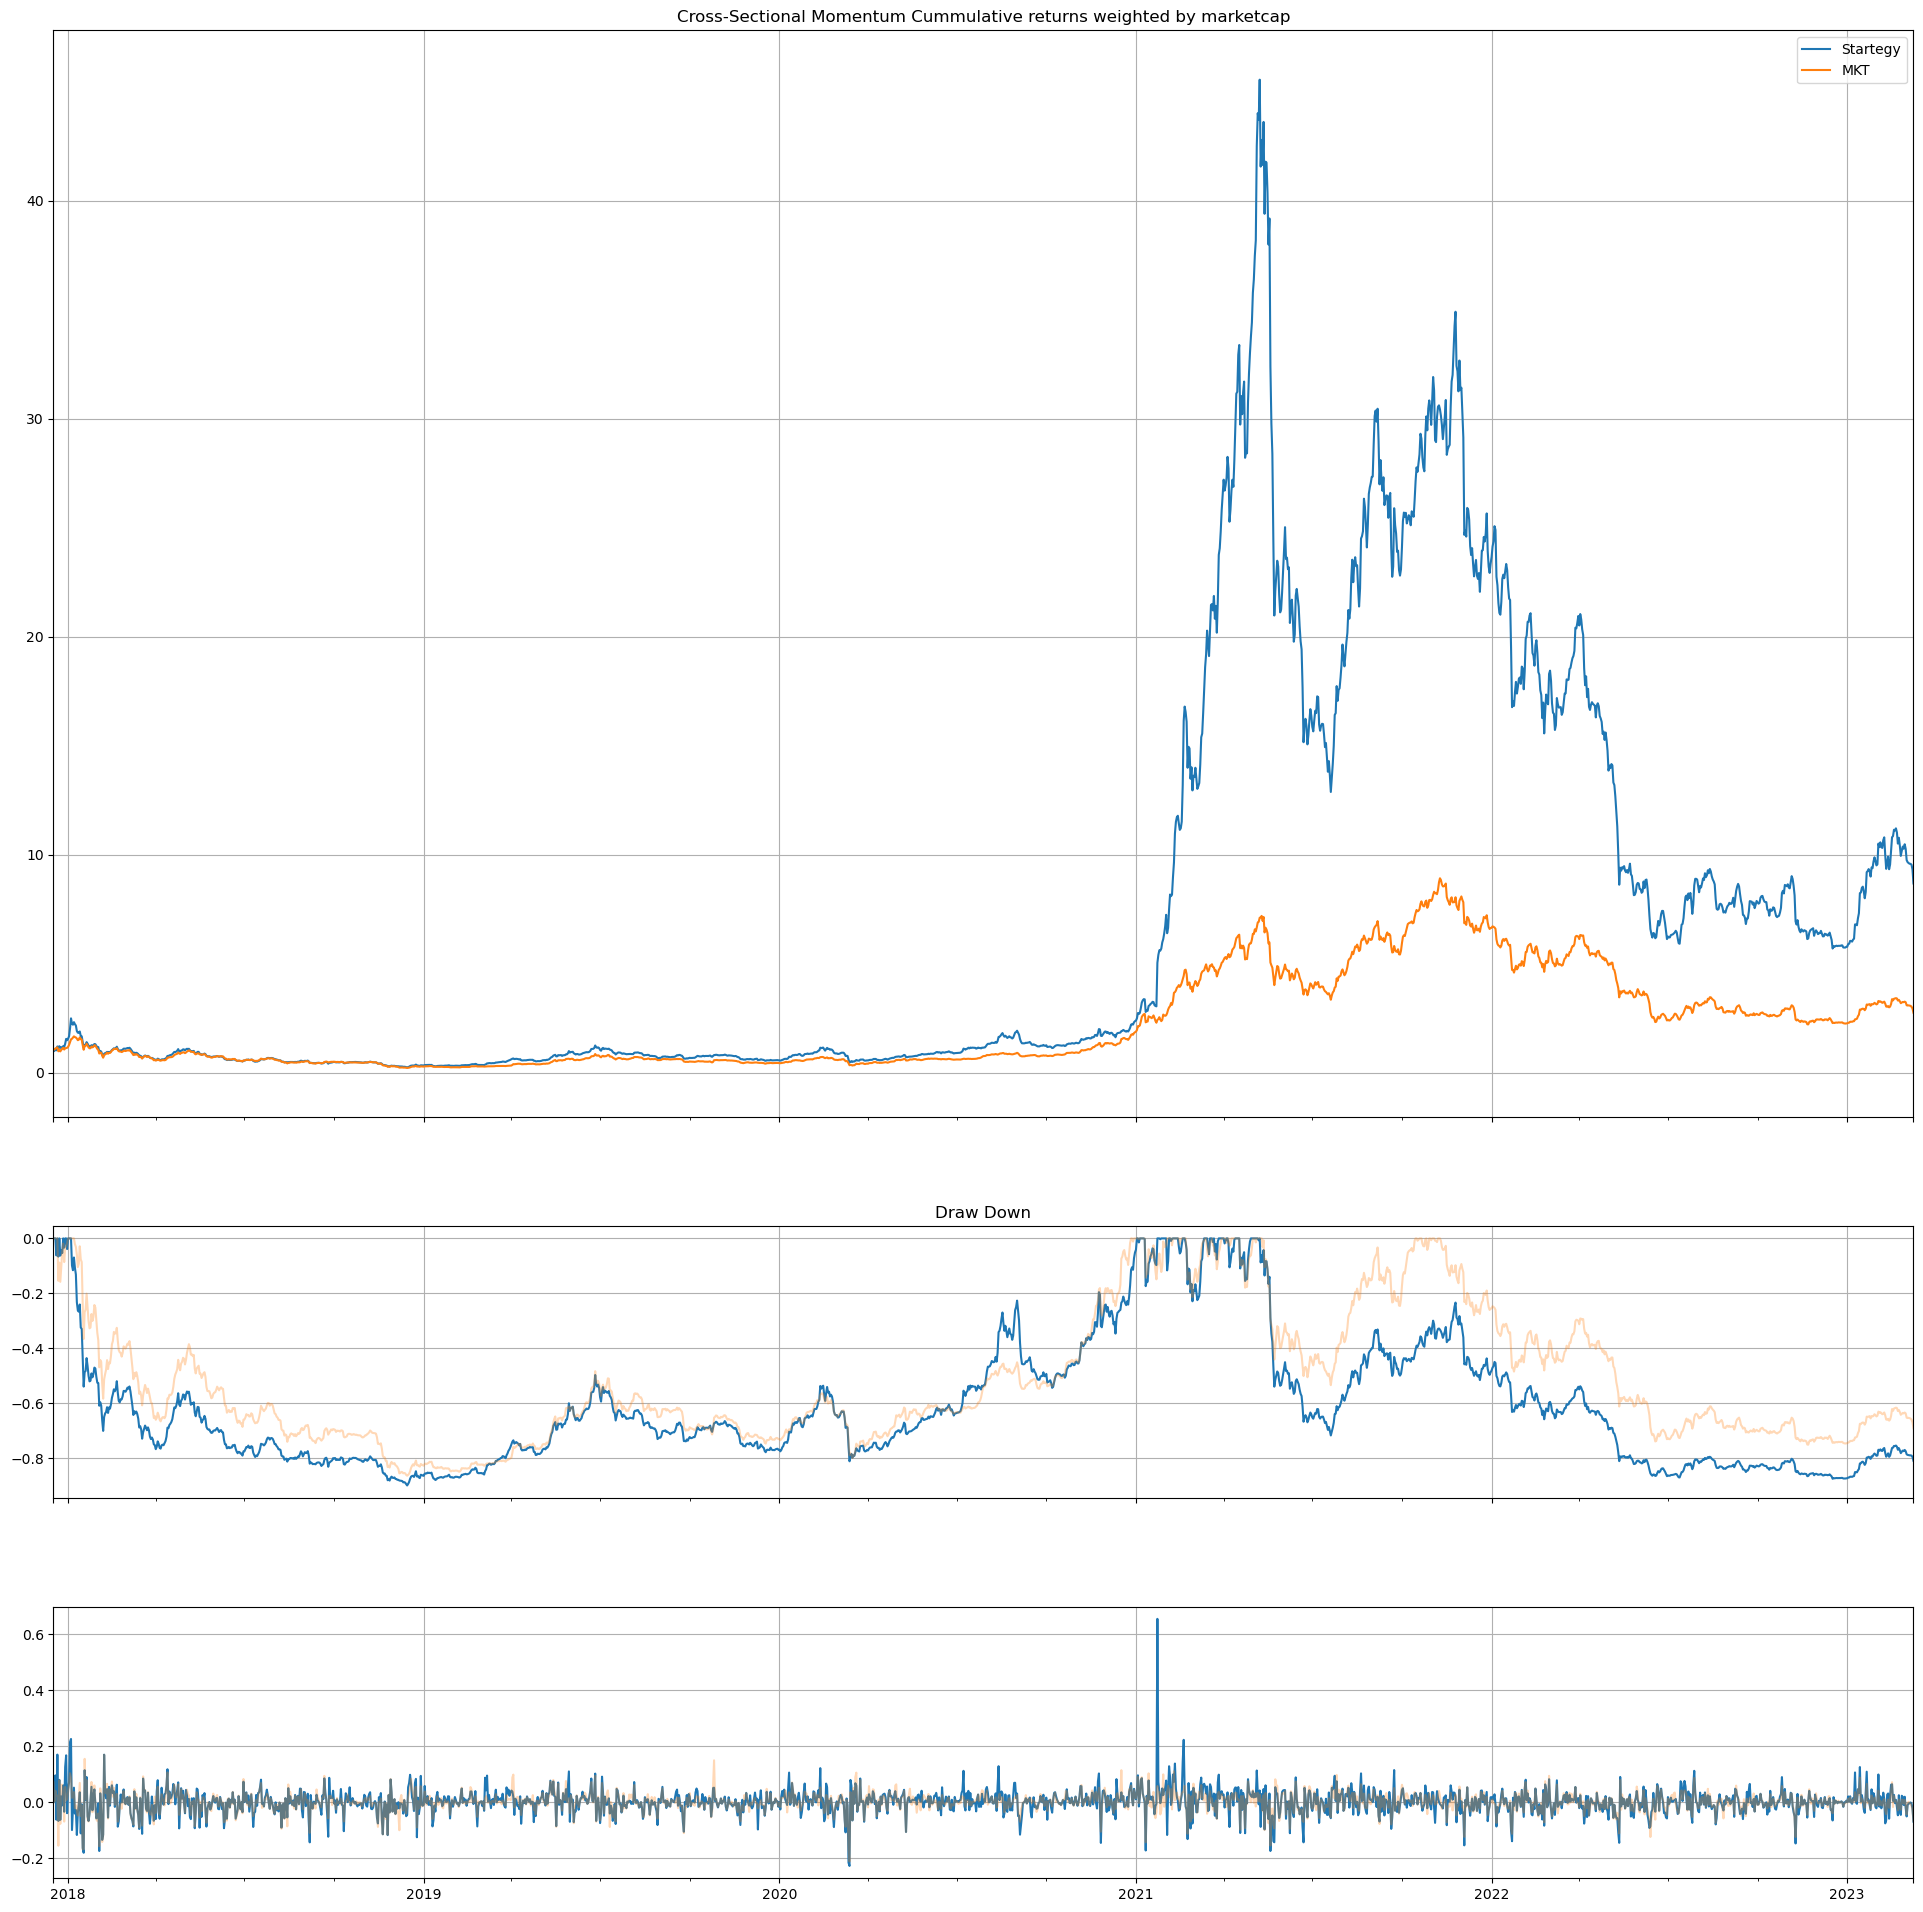

In [19]:
draw_return_result(rtn_dict, with_mkt=True, 
                   mkt_rtn=mktrtn_sample)

In [20]:
print_statistics(rtn_dict,
                 mkt_rtn=mktrtn_sample)

,0,1,2,3,4,MKT
CAGR,-73.330020,-42.381899,-27.565130,20.542204,51.164548,19.809313
Mean,-0.002569,-0.000664,-0.000160,0.001277,0.002079,0.001117
STD,0.045380,0.040978,0.037718,0.038775,0.044057,0.033959
Shape,-1.081546,-0.309576,-0.081044,0.629194,0.901546,0.628540


In [21]:
run_alpha_regression(rtn_dict,
                     mkt_rtn=mktrtn_sample)

Q1 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.719     
Dependent Variable: y                AIC:                -8816.6817
Date:               2023-04-07 14:01 BIC:                -8805.5720
No. Observations:   1910             Log-Likelihood:     4410.3    
Df Model:           1                F-statistic:        4887.     
Df Residuals:       1908             Prob (F-statistic): 0.00      
R-squared:          0.719            Scale:              0.00057855
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const       -0.0038     0.0006   -6.9644   0.0000   -0.0049   -0.0028
0            1.1333     0.0162   69.9079   0.0000    1.1015    1.1651
-------------------------------------------------------------------
Omnibus:             307.337       